In [1]:
import numpy as np      
import pandas as pd     
import seaborn as sns
import glob
import re
import codecs

from text_unidecode import unidecode
from typing import Dict, List, Tuple
from sklearn.linear_model import LinearRegression
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

#Visualizations
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=0.9, rc={"lines.linewidth": 1.8})
import matplotlib.pyplot as plt  

[nltk_data] Downloading package punkt to /Users/shringa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # allow multiple outputs in a cell
import warnings
warnings.filterwarnings("ignore")

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 6000

### Data Overview

The dataset presented here contains argumentative essays written by U.S students in grades 6-12. These essays were annotated by expert raters for **discourse elements** commonly found in argumentative writing:  

- **Lead** - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
- **Position** - an opinion or conclusion on the main question
- **Claim** - a claim that supports the position
- **Counterclaim** - a claim that refutes another claim or gives an opposing reason to the position
- **Rebuttal** - a claim that refutes a counterclaim
- **Evidence** - ideas or examples that support claims, counterclaims, or rebuttals.
- **Concluding Statement** - a concluding statement that restates the claims

### Train Data 

The training set consist of a .csv file containing the annotated discourse elements each essay, including the quality ratings, together with .txt files containing the full text of each essay. It is important to note that some parts of the essays will be unannotated (i.e., they do not fit into one of the classifications above) and they will lack a quality rating. We do not include the unannotated parts in train.csv.

- **train.csv** - Contains the annotated discourse elements for all essays in the test set.  
    -**discourse_id** - ID code for discourse element  
    -**essay_id** - ID code for essay response. This ID code corresponds to the name of the full-text file in the train/ folder.  
    -**discourse_text** - Text of discourse element.  
    -**discourse_type** - Class label of discourse element.  
    -**discourse_type_num** - Enumerated class label of discourse element .  
    -**discourse_effectiveness** - Quality rating of discourse element, the target.  

## Task I: Load Data 

In [138]:
file_name = '../../data/feedback-effectiveness/test.csv'
test_data = pd.read_csv(file_name)
test_data.shape

(10, 4)

In [12]:
filepath = '../../data/feedback-effectiveness/train.csv'
train_data = pd.read_csv(filepath)
train_data.shape

(36765, 5)

In [13]:
train_data.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,Adequate


In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [15]:
train_data.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,0013cc385424,91B1F82B2CF1,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


In [16]:
train_data.isnull().sum()

discourse_id               0
essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
dtype: int64

### Label and Disclosure Analysis

In [17]:
percentage_discourse = round(100 * train_data['discourse_effectiveness'].value_counts() / train_data.shape[0], 1)
percentage_discourse

Adequate       57.1
Effective      25.4
Ineffective    17.6
Name: discourse_effectiveness, dtype: float64

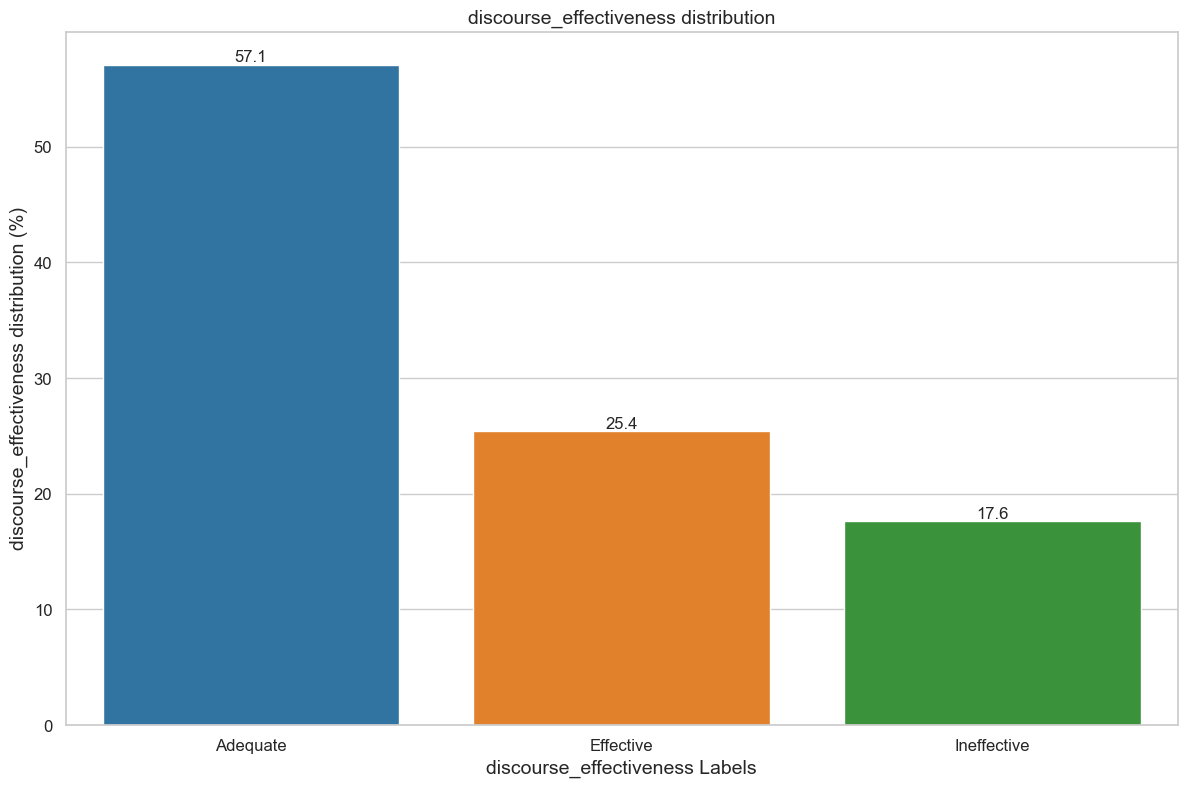

In [18]:
plt.figure(figsize=(12,8))

plt.title('discourse_effectiveness distribution', fontsize = 14)
plt.xlabel('discourse_effectiveness Labels', fontsize = 14)
plt.ylabel('discourse_effectiveness distribution (%)', fontsize = 14)
ax= sns.barplot(x =percentage_discourse.index, y =percentage_discourse.values)
for i in ax.containers:
    ax.bar_label(i, fontsize = 12)
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();

### Discourse Type Distribution

In [19]:
percentage_discourse_type = round(100 * train_data['discourse_type'].value_counts() / train_data.shape[0], 1)
percentage_discourse_type

Evidence                32.9
Claim                   32.6
Position                10.9
Concluding Statement     9.1
Lead                     6.2
Counterclaim             4.8
Rebuttal                 3.4
Name: discourse_type, dtype: float64

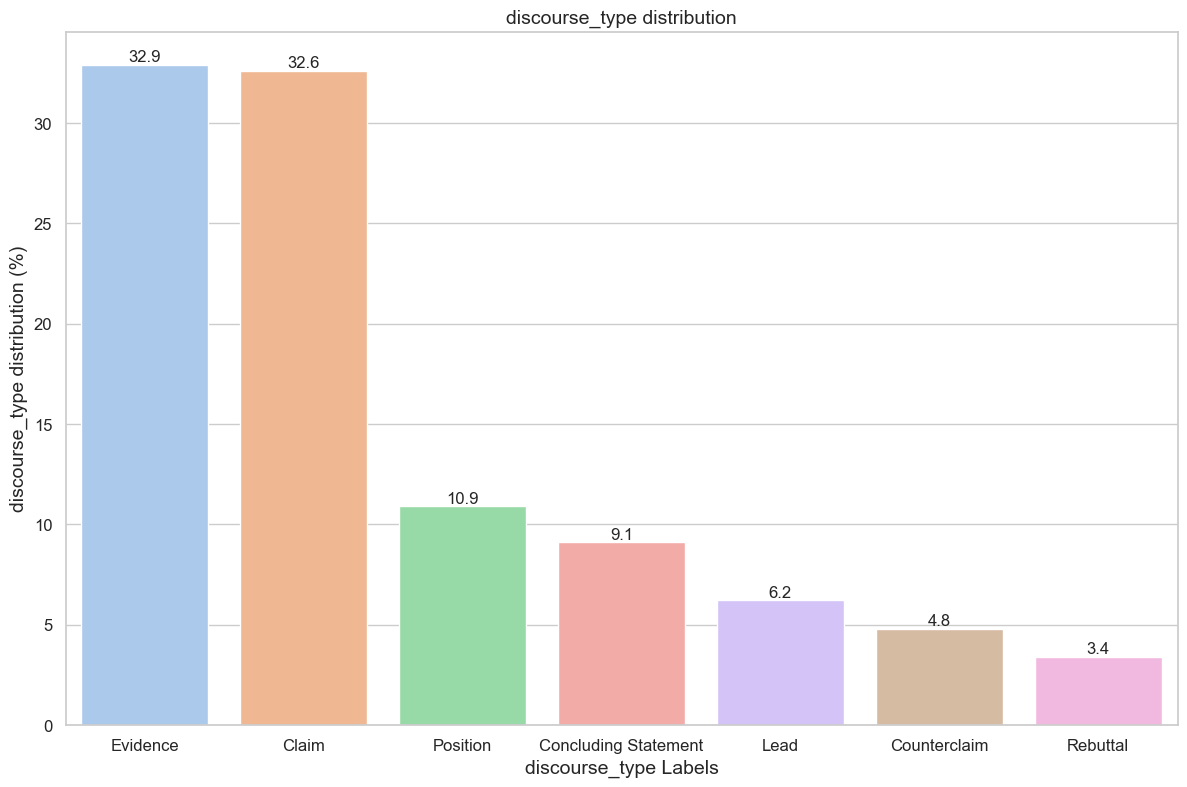

In [20]:
plt.figure(figsize=(12,8))

plt.title('discourse_type distribution', fontsize = 14)
plt.xlabel('discourse_type Labels', fontsize = 14)
plt.ylabel('discourse_type distribution (%)', fontsize = 14)
ax= sns.barplot(x = percentage_discourse_type.index, y = percentage_discourse_type.values, palette= 'pastel')
for i in ax.containers:
    ax.bar_label(i, fontsize = 12)
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();

In [21]:
effectiveness_by_type = round((train_data.groupby(['discourse_effectiveness','discourse_type'])['essay_id'].count()/train_data.groupby(['discourse_effectiveness'])['essay_id'].count())*100,2)
effectiveness_by_type = effectiveness_by_type.reset_index()
effectiveness_by_type = effectiveness_by_type.sort_values(by=['discourse_effectiveness','essay_id'], ascending=False)
effectiveness_by_type


,discourse_effectiveness,discourse_type,essay_id
17,Ineffective,Evidence,48.84
14,Ineffective,Claim,22.83
15,Ineffective,Concluding Statement,8.99
19,Ineffective,Position,7.27
18,Ineffective,Lead,5.63
20,Ineffective,Rebuttal,3.27
16,Ineffective,Counterclaim,3.17
7,Effective,Claim,36.51
10,Effective,Evidence,30.94
8,Effective,Concluding Statement,8.85


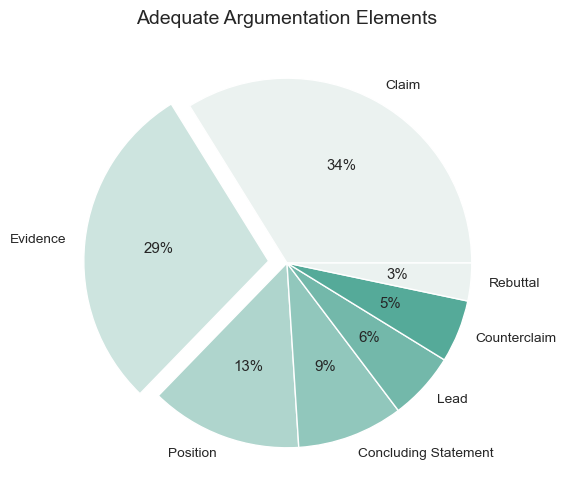

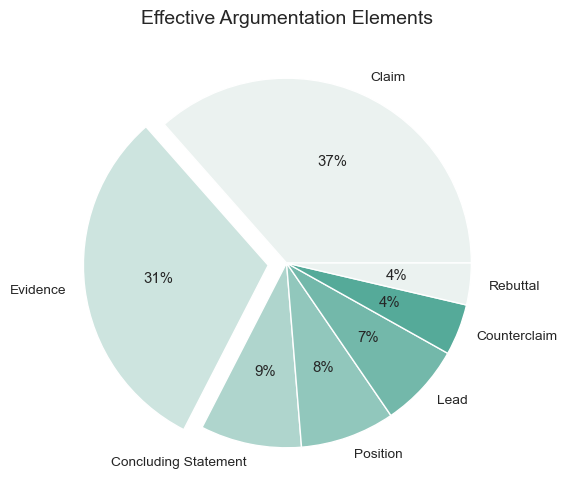

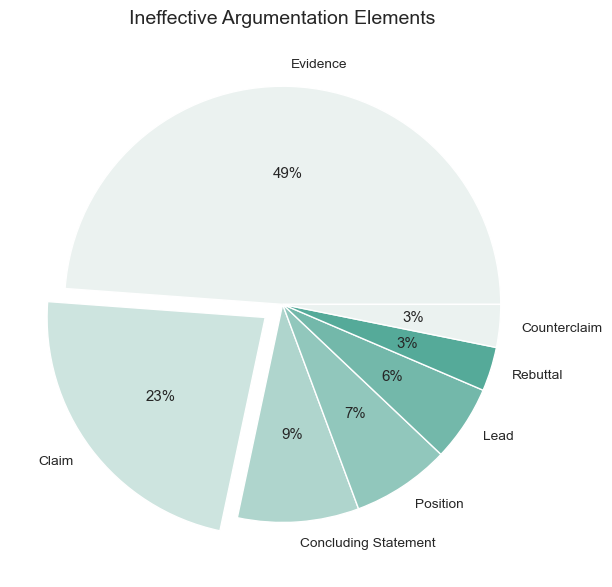

In [22]:


# define Seaborn color palette to use
palette_color = sns.color_palette("light:#5A9")

effective_labels= ['Adequate', 'Effective','Ineffective']
for i in effective_labels:
    # create figure
    fig, ax = plt.subplots(figsize = (12, 6))
    pie_values = list(effectiveness_by_type[effectiveness_by_type.discourse_effectiveness == i]['essay_id'])
    pie_labels = list(effectiveness_by_type[effectiveness_by_type.discourse_effectiveness == i].discourse_type)
    # plotting data on chart
    plt.pie(pie_values,labels=pie_labels,colors=palette_color, autopct='%.0f%%', explode=(0,0.1,0,0,0,0,0))
    plt.title(f'{i} Argumentation Elements', fontsize = 14)  


# displaying chart
plt.tight_layout();

**Claim** stands to be more effective and adequate than **Evidence** provided for the given argument. However, higher **evidence** shows ineffective argument.

### Wordcloud

In [23]:
train_data.head(1)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate


In [24]:
stopwords = STOPWORDS.update(["people", "student", "students", "teacher", "will", "one"])


<Figure size 1900x1200 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

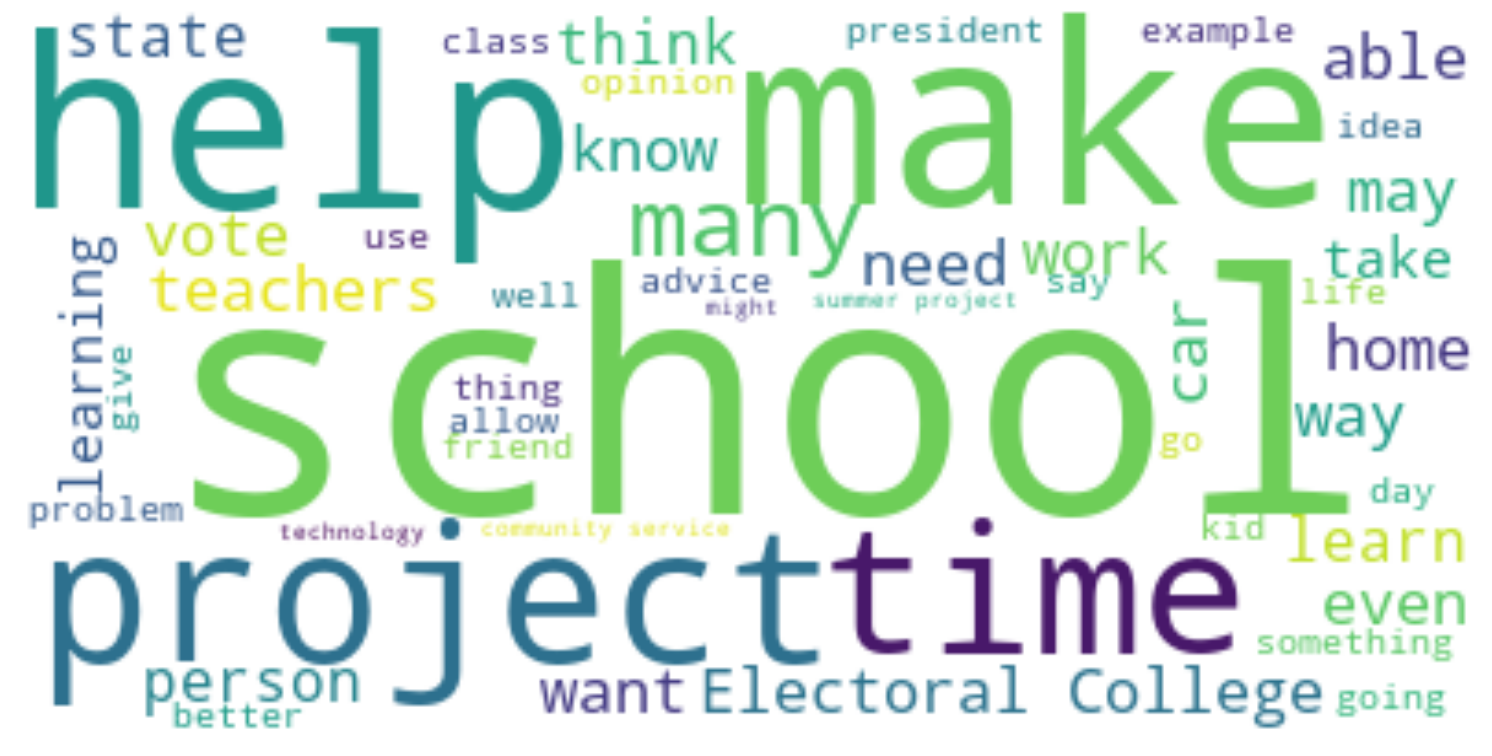

In [25]:
text = " ".join(i for i in train_data[train_data.discourse_effectiveness == 'Effective'].discourse_text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", normalize_plurals=True,  max_words=50).generate(text)
plt.figure( figsize=(19,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<Figure size 1900x1200 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

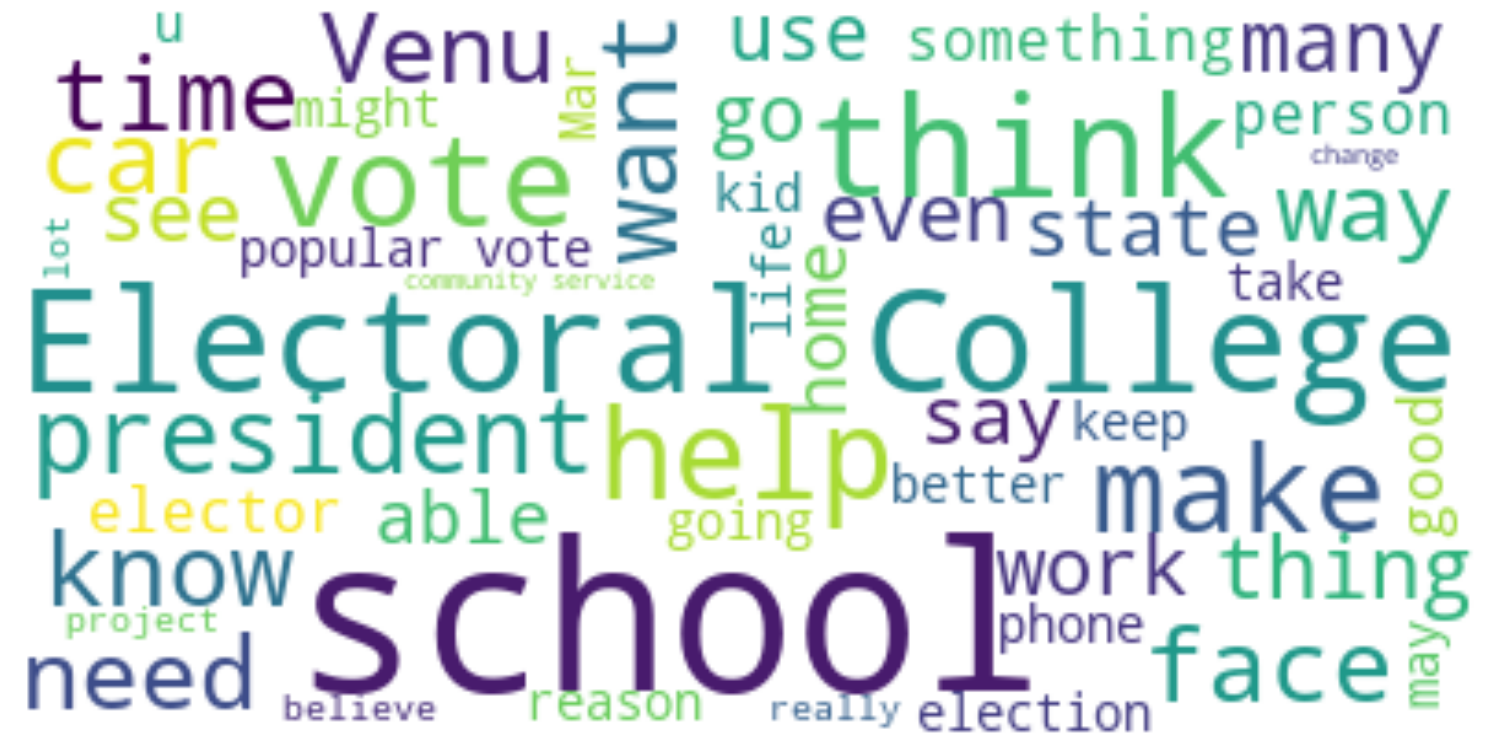

In [26]:
text = " ".join(i for i in train_data[train_data.discourse_effectiveness == 'Adequate'].discourse_text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=50, normalize_plurals=True).generate(text)
plt.figure( figsize=(19,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<Figure size 1000x1000 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

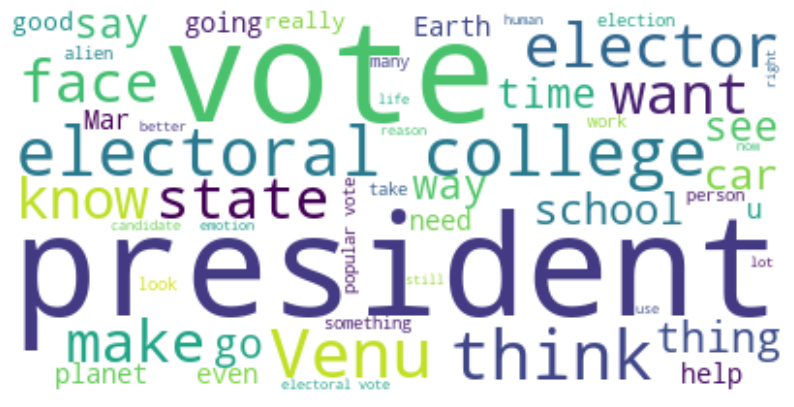

In [27]:
text = " ".join(i for i in train_data[train_data.discourse_effectiveness == 'Ineffective'].discourse_text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", normalize_plurals=True, max_words=50).generate(text)
plt.figure( figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# normalize_plurals=True

## No. of essays present in the training folder and training data

In [28]:
essay_filepath = '../../data/feedback-effectiveness/train/'
essay_data =len(glob.glob1(essay_filepath,"*.txt"))
print("Essay text files in the train folder: ",essay_data)

Essay text files in the train folder:  4191


In [29]:
print("Unique essay in the training dataset: ",train_data.essay_id.nunique())

Unique essay in the training dataset:  4191


In [30]:
discourse_types = train_data.discourse_type.unique()
discourse_types

array(['Lead', 'Position', 'Claim', 'Evidence', 'Counterclaim',
       'Rebuttal', 'Concluding Statement'], dtype=object)

In [31]:
from IPython.core.display import display, HTML

def show_examples_for_discourse_type(discourse_type, topic):
    filt = train_data.query(f'discourse_type == "{discourse_type}"').query(f'topic == {topic}').sample(frac=1, random_state=420)
    display(HTML(
        f"""
        <h4><code>{discourse_type}</code> examples</h4>
        <table>
            <tr>
              <th width=33%>Ineffective</th>
              <th width=33%>Adequate</th>
              <th width=33%>Effective</th>
            </tr>
            <tr>
              <td>{filt.query("discourse_effectiveness == 'Ineffective'").iloc[0].discourse_text}</td>
              <td>{filt.query("discourse_effectiveness == 'Adequate'").iloc[0].discourse_text}</td>
              <td>{filt.query("discourse_effectiveness == 'Effective'").iloc[0].discourse_text}</td>
            </tr>
        </table>
        """
    ))

In [32]:
# for dt in discourse_types: show_examples_for_discourse_type(dt, 10)

## What are the top topics in the essay

In [33]:
topic_pred_df = pd.read_csv('topic_model_feedback.csv')
topic_pred_df = topic_pred_df.drop(columns={'prob'})
topic_pred_df = topic_pred_df.rename(columns={'id': 'essay_id'})

topic_meta_df = pd.read_csv('topic_model_metadata.csv')
topic_meta_df = topic_meta_df.rename(columns={'Topic': 'topic', 'Name': 'topic_name'}).drop(columns=['Count'])
topic_meta_df.topic_name = topic_meta_df.topic_name.apply(lambda n: ' '.join(n.split('_')[1:]))

topic_pred_df = topic_pred_df.merge(topic_meta_df, on='topic', how='left')

train_df = train_data.merge(topic_pred_df, on='essay_id', how='left')

In [34]:
train_df.shape

(36765, 7)

In [35]:
train_df['topic_name'].value_counts()[:10]

electoral vote college electoral college        7817
students online school classes                  3822
emotions technology computer facial             3093
venus planet earth author                       2757
face mars aliens landform                       2660
students summer project projects                2641
community service community service help        2472
advice people multiple opinions                 1970
cars driverless car driverless cars             1925
extracurricular activity activities students    1596
Name: topic_name, dtype: int64

<Axes: xlabel='count', ylabel='topic_name'>

Text(0.5, 1.0, 'Topic distribution')

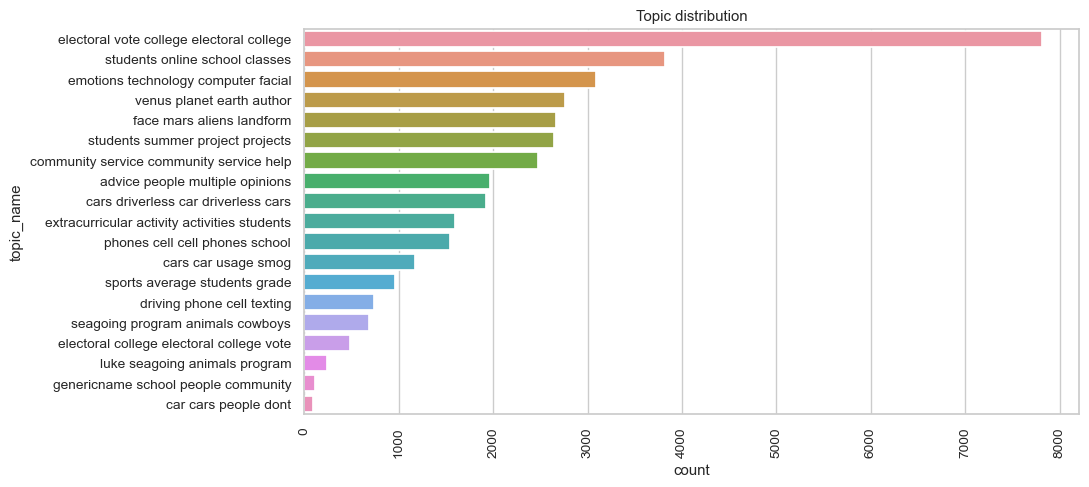

In [36]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
 
sns.countplot(y="topic_name", data=train_df, linewidth=1.25, alpha=1, ax=ax, zorder=2, orient='v',order = train_df['topic_name'].value_counts().index)
ax.set_title("Topic distribution")

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
fig.show()

## Cleaning Data

In [37]:
def detect_special_characer(pass_string): 
    regex= re.compile('[@_!#ÃÅ$%^&*()<>?/\\\|}{~:[\]]')
    if(regex.search(pass_string) == None): 
        res = False
    else: 
        res = True
    return(res)

In [38]:
train_df['check_text'] = train_df.apply(lambda x : detect_special_characer(x['discourse_text']), axis = 1)
train_df['check_text'].value_counts()

False    31910
True      4855
Name: check_text, dtype: int64

In [46]:
train_df[train_df['check_text']== True].head(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,topic,topic_name,check_text
9,d226f06362f5,00944C693682,"Limiting the usage of cars has personal and professional support all across the globe and yet it has yet to be embraced everywhere. Statistical proof show where it may help and real life examples of some of the effects of reducing, or getting rid of altogether, cars in one's daily life. While ""recent studies suggest that Americans are buying fewer cars, driving less and getting fewer licenses as each year goes by"" (Source 4), is that really enough or for the right reason? There are plenty of reasons to stop, or limit, the amount of cars being driven on the roads for every kind of person, from the hippie to the businessman, from the mom to the college student.",Lead,Effective,10,cars car usage smog,True
12,a6fcdd9110ab,00944C693682,"It is no secret that morning traffic jams and 5'o'clock traffic is often enough to send any driver into a fit of unadulterated rage and what better way is there to prevent that than to simply not drive at all? Mother and media trainer, Heidrum Walter attested to this after moving into a mostly car-less community, claiming ""when [she] had a car [she] was always tense. [She's] much happier [that] way"" (Source 1). If that were not enough, businessman Carlos Arturo Plaza who participated in the Day Without Cars in Bogota, Colombia, after just a day was able to say ""it's a good oppurtunity to take away stress"" (Source 3). Just one day was enough to de-stress this man and if that does not speak wonders, one has to wonder what does. The event ""[left] the streets of [Bogota] eerily devoid of traffic jams"" (Source 3), which goes to show how stressful it was everyday, with traffic jams a common occurance. No one enjoys them, so why continue to suffer through them?",Evidence,Effective,10,cars car usage smog,True


In [50]:
# https://www.kaggle.com/competitions/feedback-prize-2021/discussion/313330
def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

In [56]:
train_df['discourse_text_norm'] = train_df['discourse_text'].apply(resolve_encodings_and_normalize)

In [142]:
# test_data.head(2)

In [140]:
test_data['discourse_text_norm'] = test_data['discourse_text'].apply(resolve_encodings_and_normalize)

### Tokenize 

In [84]:
text = [len(sent_tokenize(text=row,language = 'english')) for row in train_df['discourse_text_norm']]
train_df['text_sentence_num'] = train_df.apply(lambda x : len(sent_tokenize(text=x['discourse_text_norm'],language = 'english')), axis = 1)
train_df['text_word_count'] = train_df.apply(lambda x : len(x['discourse_text_norm'].split()), axis = 1)
train_df['text_char_count'] = train_df.apply(lambda x : len(x['discourse_text_norm']), axis = 1)

In [85]:
train_df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,topic,topic_name,check_text,discourse_text_norm,text_sentence_num,text_word_count,text_char_count
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,3,face mars aliens landform,False,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",3,67,317
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate,3,face mars aliens landform,False,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",2,41,210
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,Adequate,3,face mars aliens landform,False,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,1,21,105
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,Adequate,3,face mars aliens landform,False,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",4,72,362
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,Adequate,3,face mars aliens landform,False,People thought that the face was formed by alieans because they thought that there was life on Mars.,1,18,101


<Figure size 1000x1000 with 0 Axes>

<Axes: xlabel='text_sentence_num', ylabel='Count'>

Text(0.5, 1.0, 'Number of sentence')

(0.0, 15.0)

,count,mean,std,min,25%,50%,75%,max
discourse_effectiveness,,,,,,,,
Adequate,20977.0,1.908280,1.600283,1.0,1.0,1.0,2.0,41.0
Effective,9326.0,3.012438,2.700820,1.0,1.0,2.0,4.0,37.0
Ineffective,6462.0,2.497524,2.985376,1.0,1.0,1.0,3.0,40.0


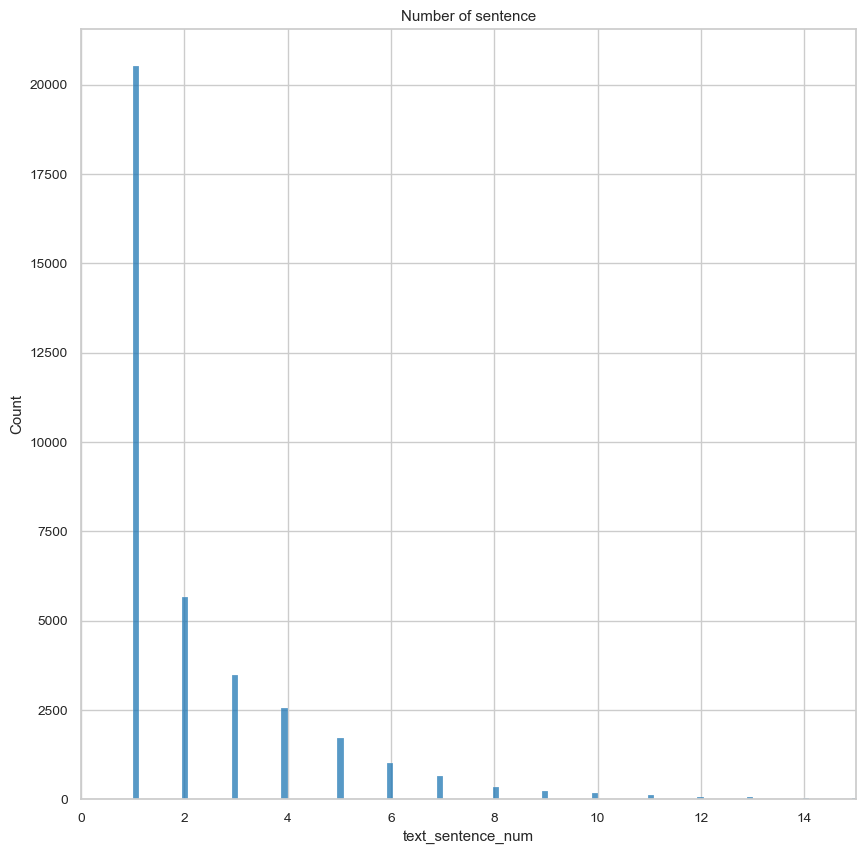

In [87]:
plt.figure(figsize=(10,10))
sns.histplot(data=train_df, x ='text_sentence_num')
plt.title('Number of sentence')
plt.xlim(0,15)
train_df.groupby('discourse_effectiveness')['text_sentence_num'].describe()

In [135]:
def hist_plot_discourse(df,x,filter_value ,hue, limit, color, title):
    
    df = df[df.discourse_effectiveness == filter_value]
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.histplot(data=df, x =x, hue = hue, palette =color) 
    axs.axvline(x=df[x].mean(),color='red',linestyle='--')
    axs.set_xlim(0,limit)
    axs.xaxis.set_ticks(np.arange(0, limit, 50))
    axs.set_title(title)

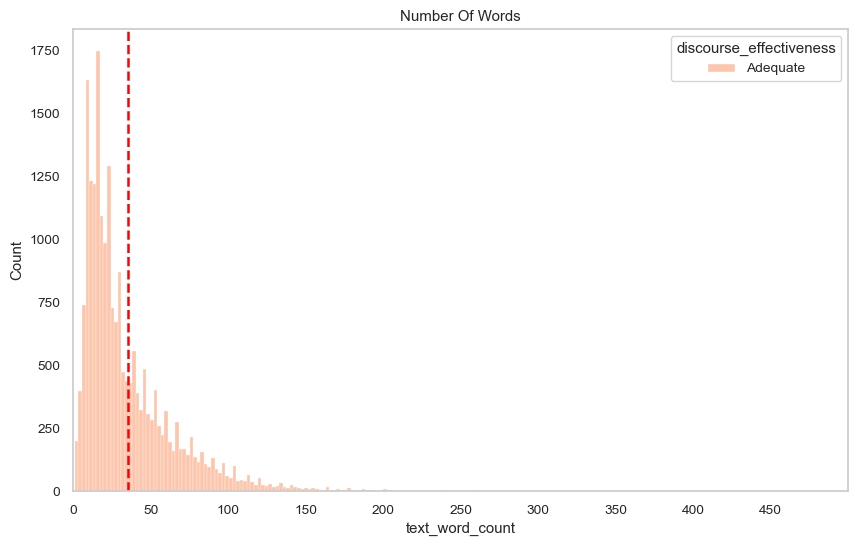

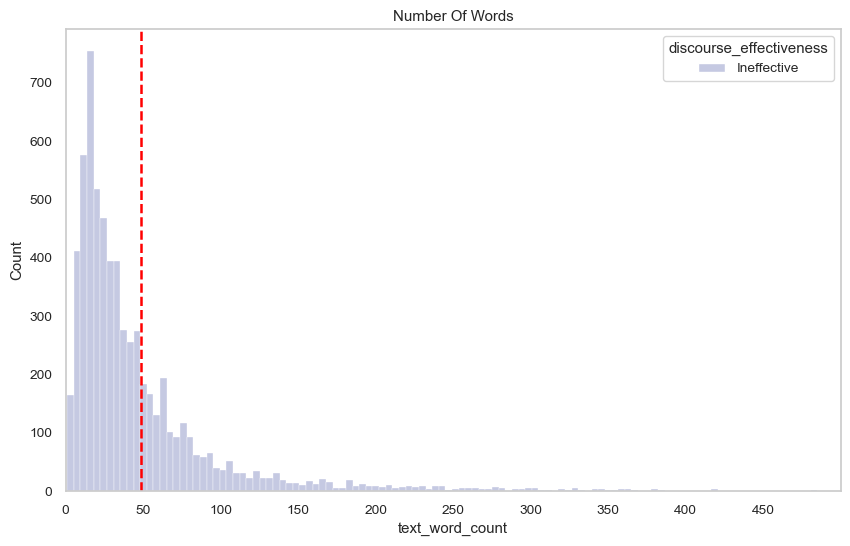

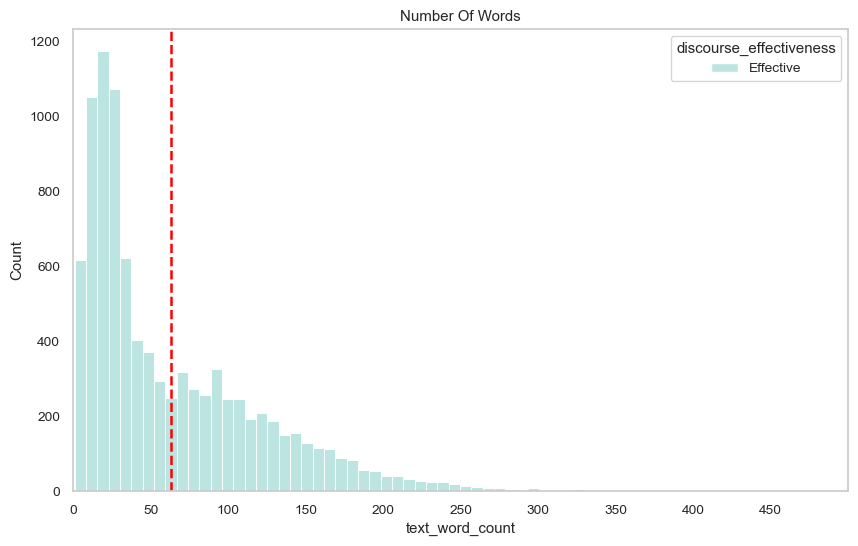

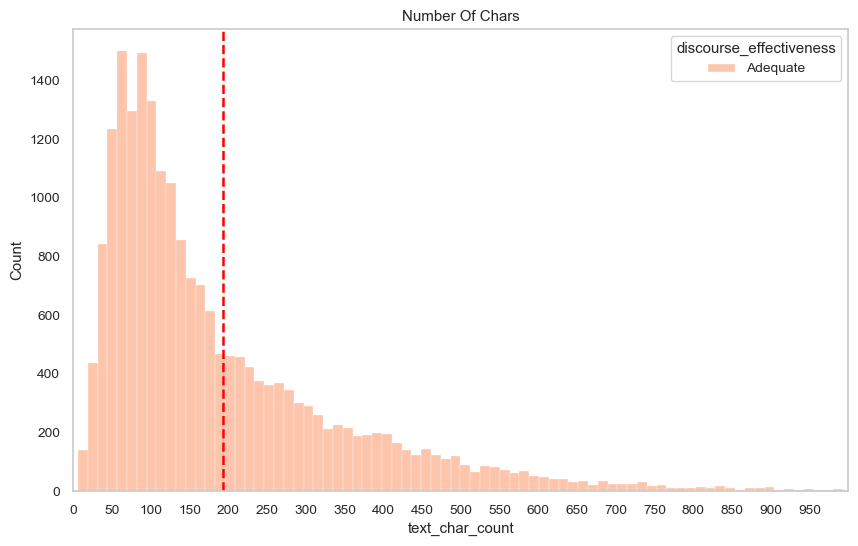

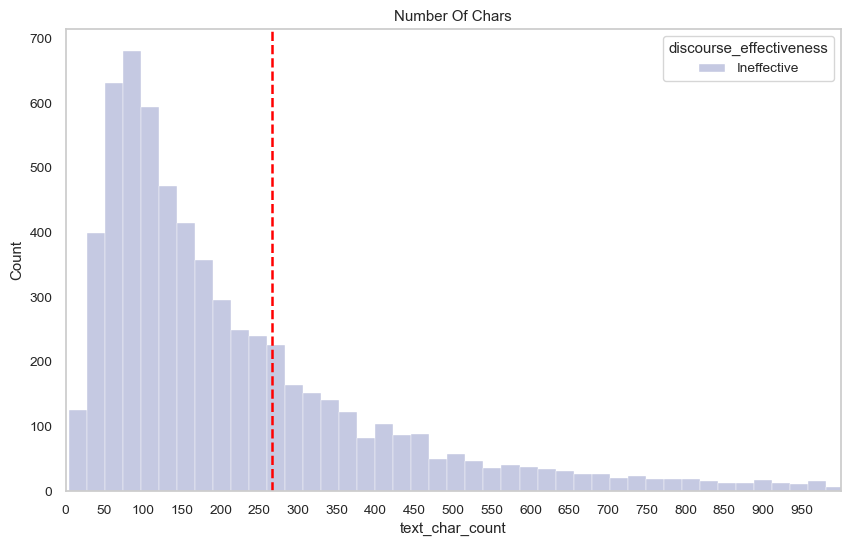

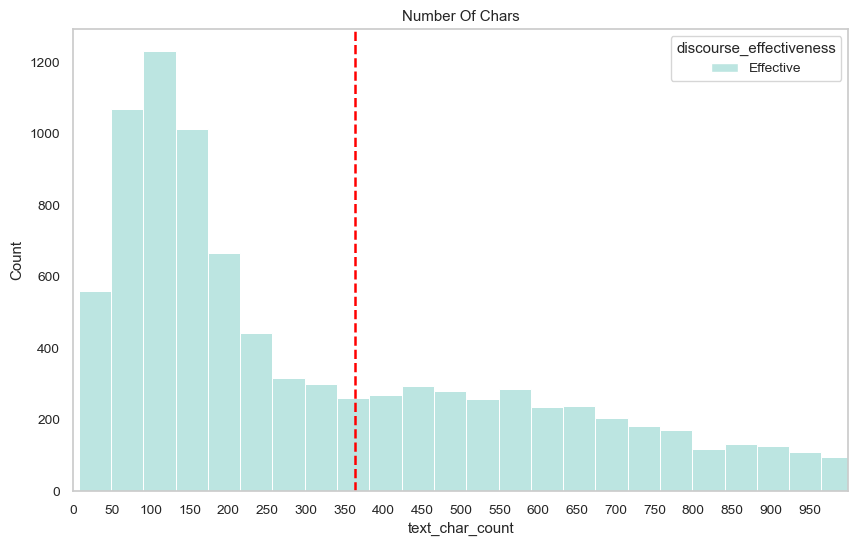

In [136]:
plot_dict = {'Adequate':'OrRd', 'Ineffective':'BuPu', 'Effective':'GnBu'}

for key,color in plot_dict.items():
    figs, axs = plt.subplots(1,1,figsize=(10,6))
    hist_plot_discourse(train_df,'text_word_count',key,'discourse_effectiveness',500, color, 'Number Of Words')
    
for key,color in plot_dict.items():
    figs, axs = plt.subplots(1,1,figsize=(10,6))    
    hist_plot_discourse(train_df,'text_char_count',key,'discourse_effectiveness',1000, color, 'Number Of Chars')

In [137]:
# train_df.to_csv('../../data/feedback-effectiveness/eda_train_data.csv')

In [ ]:
# test_data.to_csv('../../data/feedback-effectiveness/eda_train_data.csv')